In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from transformers import BertModel, BertConfig

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

MAX_SEQ_LEN = 20  # Max number of past movies to consider
EMBEDDING_DIM = 128 # Dimension of the movie embedding
BATCH_SIZE = 32
EPOCHS = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

C:\Users\nikra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Prepare the preprocessed data embeddings
movie_embeddings = pd.read_pickle("Dataset_Processed/Movie_Embeddings.pkl")

# Extract features for training
features = np.array(list(movie_embeddings['Description_Embedding']))    # Description embeddings
keywords = np.array(list(movie_embeddings['Keyword_Embedding']))        # Keyword embeddings
genres = movie_embeddings.loc[:, "Action":"Western"].values             # Genre embeddings
countries = movie_embeddings.loc[:, "Afghanistan":"Zimbabwe"].values    # Country embeddings
other_features = movie_embeddings[["Adult","Normalized_Release_Year","Normalized_Rating","Normalized_Popularity"]].values

# Training Features
X = np.hstack((features, keywords, genres, countries, other_features)) 
# Training Labels
y = movie_embeddings['ID'].values 

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


print(f"Features shape (X): {X.shape}") 
print(f"Labels shape   (y): {y.shape}") 

Features shape (X): (14010, 1707)
Labels shape   (y): (14010,)


### Define Transformer-Based Model (SASRec/BERT4Rec-like)

In [3]:
class TransformerRecModel(nn.Module):
    def __init__(self, num_movies, input_dim, embedding_dim, num_heads, num_layers):
        super().__init__()
        self.input_projection = nn.Linear(input_dim, embedding_dim)  # Project features to embedding_dim
        self.positional_embedding = nn.Embedding(MAX_SEQ_LEN, embedding_dim)
        self.transformer = nn.Transformer(d_model=embedding_dim, nhead=num_heads, num_encoder_layers=num_layers, num_decoder_layers=num_layers)
        self.output_layer = nn.Linear(embedding_dim, num_movies)
        self.max_seq_len = MAX_SEQ_LEN

    def forward(self, features, input_ids=None):
        # Project features into embedding space
        projected_features = self.input_projection(features)
        
        # Determine sequence length
        seq_len = self.max_seq_len if input_ids is None else min(input_ids.size(1), self.max_seq_len)
        
        # Expand projected features to match sequence length
        projected_features = projected_features.unsqueeze(1).expand(-1, seq_len, -1)

        # Add positional embeddings
        pos_embeds = self.positional_embedding(torch.arange(seq_len, device=features.device))
        combined_embeds = projected_features + pos_embeds

        # Transpose for transformer (seq_len, batch_size, embedding_dim)
        combined_embeds = combined_embeds.permute(1, 0, 2)

        # Apply transformer
        transformer_output = self.transformer(combined_embeds, combined_embeds)

        # Output probabilities for next movie
        output = self.output_layer(transformer_output[-1])  # Last position
        return output

### Training Function

In [4]:
# Training function
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in dataloader:
        features, targets = batch
        features, targets = features.to(device), targets.to(device)

        optimizer.zero_grad()
        output = model(features, features) 
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(dataloader)

C:\Users\nikra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/10, Loss: 9.5627
Epoch 2/10, Loss: 9.6788
Epoch 3/10, Loss: 9.5531
Epoch 4/10, Loss: 9.4402
Epoch 5/10, Loss: 9.4165
Epoch 6/10, Loss: 9.4011
Epoch 7/10, Loss: 9.3895
Epoch 8/10, Loss: 9.3845
Epoch 9/10, Loss: 9.3791
Epoch 10/10, Loss: 9.3743
Model saved successfully.
Full model saved successfully.


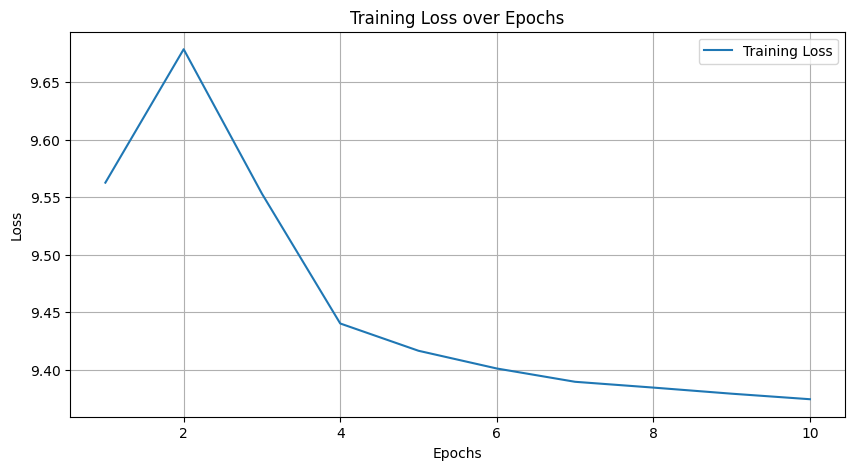

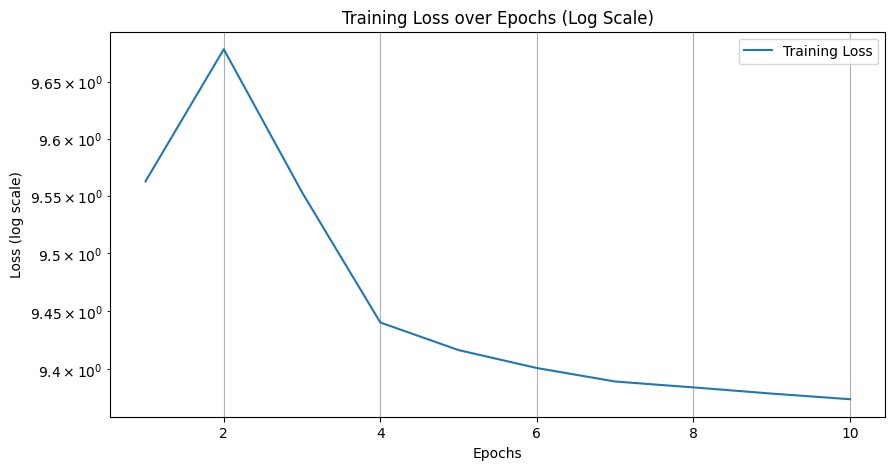

In [ ]:
if __name__ == "__main__":
    # Dataset and Dataloader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    
    # Initialize Model, Optimizer, and Loss Function
    model = TransformerRecModel(num_movies=y_train_tensor.max().item() + 1, input_dim=X_train_tensor.shape[1], embedding_dim=EMBEDDING_DIM, num_heads=4, num_layers=2)
    model.to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # Lists to store loss values for plotting
    train_losses = []

    # Training loop
    for epoch in range(EPOCHS):
        train_loss = train(model, train_loader, optimizer, criterion, DEVICE)
        train_losses.append(train_loss)
        print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {train_loss:.4f}")

    # Save the trained model
    torch.save(model.state_dict(), 'NN_Models/transformer_rec_model.pth')
    print("Model saved successfully.")

    # Optionally, save the entire model (including architecture)
    torch.save(model, 'NN_Models/transformer_rec_model_full.pth')
    print("Full model saved successfully.")

    # Plotting the training loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, EPOCHS + 1), train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.savefig('NN_Models/training_loss.png')
    plt.show()

    # Plotting the training loss with a log scale
    plt.figure(figsize=(10, 5))
    plt.semilogy(range(1, EPOCHS + 1), train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (log scale)')
    plt.title('Training Loss over Epochs (Log Scale)')
    plt.legend()
    plt.grid(True)
    plt.savefig('NN_Models/training_loss_log_scale.png')
    plt.show()